In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import pandas as pd
from fredpy import series, window_equalize
import datetime,dateutil,urllib,runProcs
from selenium import webdriver
import requests
%matplotlib inline

In [2]:
# 1. Import the most recent inflation forecast data from the Philadelphia Fed, Survey of Professional Forecasters

# 1.1 Current method using Requests package
url = 'https://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/data-files/files/median_pgdp_level.xls?la=en'
r = requests.get(url,verify=False)
with open("gdpDeflatorForecast.xls", "wb") as code:
    code.write(r.content)

# 1.2 Old method using urllib
# dls = "http://www.philadelphiafed.org/research-and-data/real-time-center/survey-of-professional-forecasters/data-files/files/Median_PGDP_Level.xls"
# dls = "http://www.philadelphiafed.org/-/media/research-and-data/real-time-center/survey-of-professional-forecasters/data-files/files/median_pgdp_level.xls?la=en"
# urllib.request.urlretrieve(dls, "gdpDeflatorForecast.xls")
      
# # dls = "http://www.philadelphiafed.org/research-and-data/real-time-center/survey-of-professional-forecasters/data-files/files/Median_RGDP_Level.xls"
# # urllib.urlretrieve(dls, "realGdpForecast.xls")

# # dls = "http://www.philadelphiafed.org/research-and-data/real-time-center/survey-of-professional-forecasters/data-files/files/Median_RCONSUM_Level.xls"
# # urllib.urlretrieve(dls, "realConsumptionForecast.xls")

/Users/bcjenkin/anaconda/lib/python3.4/site-packages/requests/packages/urllib3/connectionpool.py:789: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.org/en/latest/security.html
  InsecureRequestWarning)


In [3]:
# 2. Download and manage data from FRED

# 2.1 Download
interestA = series('GS1')
realInterestExAnteA = series('GS1')

popA = series('CNP16OV')


gdpDeflatorA = series('A191RD3A086NBEA')
consGrowthA= series('PCECCA')
gdpGrowthA= series('GDPCA')

# 2.2 manage data
interestA.monthtoannual(method='average')
realInterestExAnteA.monthtoannual(method='average')
popA.monthtoannual(method='end')
gdpDeflatorA.apc(method='forward')
consGrowthA.apc(method='forward')
gdpGrowthA.apc(method='forward')
popA.apc(method='forward')

win = ['07-01-1970','01-01-2200']
interestA.window(win)
realInterestExAnteA.window(win)
gdpDeflatorA.window(win)
consGrowthA.window(win)
gdpGrowthA.window(win)
popA.window(win)

In [4]:
# 3. Create forecast series as FRED objects

# 3.1 import the forecasts from Excel file

inflationForecast = pd.read_excel('gdpDeflatorForecast.xls')

# 3.2 fill in missing values by interpolation and compute the forecasted 4-quarter ahead growth rates
inflationForecast= inflationForecast.iloc[6:]
inflationForecast[['PGDP6','PGDP3','PGDP2']] = inflationForecast[['PGDP6','PGDP3','PGDP2']].interpolate()
inflationForecast['inflation A'] = 100* ( inflationForecast['PGDP6']/inflationForecast['PGDP2']-1)

# 3.2 initialize a FRED object
inflationForecastA=series('GDPDEF')

In [5]:
# 4 Define function to associate forecasts with dates.
def forecastDates(forecastDataFrame):
    dates = []
    for i,ind in enumerate(forecastDataFrame.index):
        year =int(forecastDataFrame.iloc[i]['YEAR'])
        quart=int(forecastDataFrame.iloc[i]['QUARTER'])
        if quart == 1:
            month = '04'
        elif quart == 2:
            month = '07'
        elif quart == 3:
            month = '10'
        else:
            month = '01'
            year=year+1
        date = month+'-01-'+str(year)
        dates.append(date)
    dateNumbers = [dateutil.parser.parse(s) for s in dates]
    return dates, dateNumbers

In [6]:
# 5. Create FRED forecast objects

inflationForecastA.data = inflationForecast['inflation A'].values.tolist()
inflationForecastA.dates, inflationForecastA.datenumbers = forecastDates(inflationForecast)
inflationForecastA.title = 'one-year ahead inflation forecast'
inflationForecastA.quartertoannual(method='average')

In [7]:
# 5.3 Create the ex ante real interest rate data
window_equalize([realInterestExAnteA,interestA,inflationForecastA,gdpDeflatorA,consGrowthA,gdpGrowthA,popA])
realInterestExAnteA.data = [i-p for i,p in zip(interestA.data,inflationForecastA.data)]
realInterestExAnteA.title = 'ex ante real interest rate'

In [8]:
# 6. Export the data

inflationForecastDf=np.round(pd.DataFrame({'1-year inflation forecast':inflationForecastA.data,'1-year actual inflation':gdpDeflatorA.data,'1-year nominal interest rate':interestA.data,'1-year ahead consumption growth':consGrowthA.data,'1-year population growth':popA.data},index = interestA.dates),4)
inflationForecastDf[[u'1-year nominal interest rate', u'1-year inflation forecast', u'1-year actual inflation', u'1-year ahead consumption growth',u'1-year population growth']].to_csv('inflationForecastDataAnnual.csv',index=True,index_label='date')

In [9]:
# 7. Plot

# 7.1 general plot settings

font = {'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)
plt.rcParams['xtick.major.pad']='8'
plt.rcParams['ytick.major.pad']='8'


# 7.2 Formatter for inserting commas in y axis labels with magnitudes in the thousands

def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:0,d}'.format(int(x))
   return s

y_format = plt.FuncFormatter(func)  # make formatter

# 7.3 format the x axis ticksticks
years2,years4,years5,years10,years15= dts.YearLocator(2),dts.YearLocator(4),dts.YearLocator(5),dts.YearLocator(10),dts.YearLocator(15)


# 7.4 y label locator for vertical axes plotting gdp
majorLocator_y   = plt.MultipleLocator(3)
majorLocator_shares   = plt.MultipleLocator(0.2)

# 7.5 Index locator
def findDateIndex(dateStr,fredObj):
    for n,d in enumerate(fredObj.dates):
        if d == dateStr:
            return n


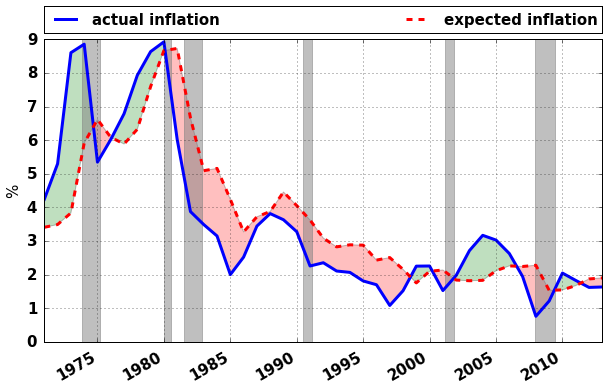

In [10]:
# 7.2 Define a function for importing pandas series into FRED objects
def pdSeriesToFRED(data,dates,title=None,t=None,season=None,freq=None,source=None,units=None,daterange=None,idCode=None,updated=None):
    f = series('UNRATE')
    f.data = data
    f.dates = dates
    f.datenums = [dateutil.parser.parse(s) for s in f.dates]
    f.title = title
    f.t = t
    f.season = season
    f.freq = freq
    f.source = source
    f.units = units
    f.daterange = daterange
    f.idCode = idCode
    f.updated = updated
    return f

# 7.3 Import from csv
rateData  = pd.read_csv('inflationForecastDataAnnual.csv')
interest = pdSeriesToFRED(data=rateData['1-year nominal interest rate'],dates=rateData['date'].tolist(),title='One-year US bond rate',freq='Annual')
realRateExAnte= pdSeriesToFRED(data=rateData['1-year nominal interest rate'],dates=rateData['date'].tolist(),title='One-year ex ante real rate',freq='Annual')
realRateExPost = pdSeriesToFRED(data=rateData['1-year nominal interest rate'],dates=rateData['date'].tolist(),title='One-year ex post real rate',freq='Annual')
expectedInflation = pdSeriesToFRED(data=rateData['1-year inflation forecast'],dates=rateData['date'].tolist(),title='One-year inflation forecast',freq='Annual')
actualInflation = pdSeriesToFRED(data=rateData['1-year actual inflation'],dates=rateData['date'].tolist(),title='One-year actual inflation',freq='Annual')
# gdpGrowth = pdSeriesToFRED(data=rateData['1-year ahead gdp growth'],dates=rateData['date'].tolist(),title='One-year ahead gdp growth',freq='Annual')
consGrowth = pdSeriesToFRED(data=rateData['1-year ahead consumption growth'],dates=rateData['date'].tolist(),title='One-year ahead consumption growth',freq='Annual')
popGrowth = pdSeriesToFRED(data=rateData['1-year population growth'],dates=rateData['date'].tolist(),title='One-year population growth',freq='Annual')


# 7.4 actual inflation, expected inflation
fig=plt.figure(figsize=(10, 6))
ax=fig.add_subplot(1,1,1)
realRateExAnte.recessions()
ax.plot_date(actualInflation.datenums,actualInflation.data,'b-',lw=3)
ax.plot_date(expectedInflation.datenums,expectedInflation.data,'r--',lw=3)
ax.fill_between(actualInflation.datenums,actualInflation.data, expectedInflation.data, where = expectedInflation.data<actualInflation.data,alpha=0.25,facecolor='green', interpolate=True)
ax.fill_between(actualInflation.datenums,actualInflation.data, expectedInflation.data, where = expectedInflation.data>actualInflation.data,alpha=0.25,facecolor='red', interpolate=True)
# ax.set_title('Actual and Expected Inflation')
ax.set_ylabel('%')
ax.xaxis.set_major_locator(years5)
ax.legend(['actual inflation','expected inflation'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0.,fontsize=15)
plt.grid()
fig.autofmt_xdate()
plt.savefig('fig_US_Inflation_Forecast_site.png',bbox_inches='tight')

In [11]:
#8. Export notebook to python script
progName = 'realRateData'
runProcs.exportNb(progName)
# runProcs.handout('Slides_'+progName)
# runProcs.tex(['Slides_'+progName,'Handout_'+progName])